## Подготовка данных

In [366]:
#Импорт библиотек
import requests
from urllib.parse import urlencode
import io

import pandas as pd
from datetime import timedelta, datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats
import pingouin as pg
import numpy as np
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm


In [367]:
#Создаем списки для загрузки таблиц через цикл
urls = ['L8HxRYDn2l4h9A', 'TxOD_JxnkMd4mA', 'YT6OWRK2cTWfLg', '3viYBnm7cyihkQ', '84jzzJeQ4tqVyg', '_pOo7mrDCZZMyA']
data_names = ['users_test', 'users_control_1', 'users_control_2', 'transactions_test', 'transactions_control_1', 'transactions_control_2']

In [368]:
# Скачиваем файлы с яндекс диска
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
for i in range(len(urls)):
    public_key = 'https://disk.yandex.ru/d/' + urls[i]
    
    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']

    # Загружаем файл и сохраняем его в датафрейм с заданным именем
    download = requests.get(download_url).content
    locals()[data_names[i]] = pd.read_csv(io.StringIO(download.decode('utf-8')), sep = ';')

Посмотрим на пропущенные значения, тип данных.

In [369]:
users_test.dtypes

uid                   int64
age                   int64
attraction_coeff      int64
coins               float64
country              object
visit_days           object
gender                int64
age_filter_start      int64
age_filter_end        int64
views_count           int64
was_premium         float64
is_premium          float64
total_revenue         int64
dtype: object

In [370]:
users_test.isna().sum()

uid                    0
age                    0
attraction_coeff       0
coins               4259
country                0
visit_days          1330
gender                 0
age_filter_start       0
age_filter_end         0
views_count            0
was_premium         3900
is_premium          4151
total_revenue          0
dtype: int64

In [371]:
users_test = users_test.fillna(0)
users_control_1 = users_control_1.fillna(0)
users_control_2 = users_control_2.fillna(0)

In [372]:
transactions_test.dtypes

uid              int64
country         object
joined_at       object
paid_at         object
revenue          int64
payment_id       int64
from_page       object
product_type    object
dtype: object

In [373]:
for data in [transactions_test, transactions_control_1, transactions_control_2]:
    data.joined_at = pd.to_datetime(data.joined_at, format='%Y-%m-%d')
    data.paid_at = pd.to_datetime(data.paid_at, format='%Y-%m-%d')

In [374]:
transactions_control_1.isna().sum()

uid             630
country         630
joined_at       630
paid_at         630
revenue         630
payment_id      630
from_page       630
product_type    630
dtype: int64

In [375]:
transactions_control_1 = transactions_control_1.dropna()

## Анализ аудитории

Посмотрим на аудиторию приложения для того, чтобы понимать на какие группы можно было бы разделить пользователей при проведении A/B теста  

 - Объединяем датафреймы с информацией о пользователях в группах
 - Смотрим на число уникальных пользователей

In [376]:
k = 0
group_names = ['test', 'control_1', 'control_2']
users_info = pd.DataFrame()
for group_data in [users_test, users_control_1, users_control_2]:
    group_data['group'] = group_names[k]
    users_info = pd.concat( [users_info, group_data]).reset_index(drop = True)
    k += 1
users_info = users_info.fillna(0)

In [377]:
users_info.head()

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,group
0,892309896,27,685,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,0.0,0.0,0,test
1,892044516,27,0,0.0,Germany,0,1,24,30,0,0.0,0.0,0,test
2,892185708,45,44,0.0,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,0.0,0.0,0,test
3,892130292,32,0,0.0,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,0.0,0.0,0,test
4,891406035,27,1000,0.0,France,0,1,24,30,1,1.0,0.0,0,test


In [378]:
users_info.uid.nunique()

12912

#### Анализ аудитории по странам
- Группируем таблицу с количеством пользователей по странам
- Строим график распределения

In [379]:
countries = users_info.groupby('country', as_index = False) \
            .agg({'uid': 'count'}) \
            .sort_values('uid', ascending = False) \
            .query('uid > 50').reset_index(drop = True)
countries = pd.concat([countries, pd.DataFrame({'country' : 'other', 'uid': users_info.groupby('country', as_index = False) \
            .agg({'uid': 'count'}) \
            .sort_values('uid', ascending = False) \
            .query('uid < 50').uid.sum()}, index = ['0'])]).reset_index(drop = True)

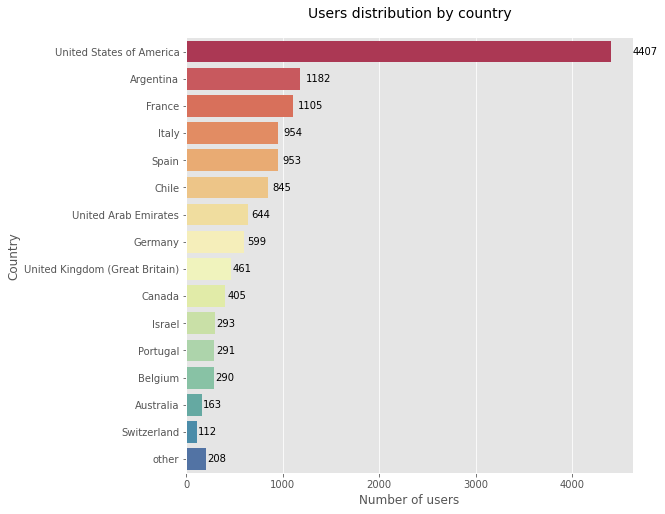

In [380]:
plt.figure(figsize = (8, 8))
ax = sns.barplot(data = countries, y = 'country', x = 'uid', palette = "Spectral")
for p in ax.patches:
        width = p.get_width()
        plt.text(1.05*p.get_width(), p.get_y()+0.5*p.get_height(),
                 '%d' % int(width),
                 ha='left', va='center')
plt.xlabel("Number of users", size=12)
plt.ylabel("Country", size=12)
plt.title('Users distribution by country', pad = 20, size = 14)
sns.despine()

In [381]:
countries.uid.describe()

count      16.000000
mean      807.000000
std      1021.086154
min       112.000000
25%       290.750000
50%       530.000000
75%       953.250000
max      4407.000000
Name: uid, dtype: float64

#### Анализ аудитории по возрасту
- Смотрим на описательную статистику возраста среди пользователей
- Строим график распределения количества пользователей по количеству лет

In [382]:
users_info.age.describe()

count    12912.000000
mean        32.010378
std         10.224415
min         16.000000
25%         25.000000
50%         30.000000
75%         38.000000
max         99.000000
Name: age, dtype: float64

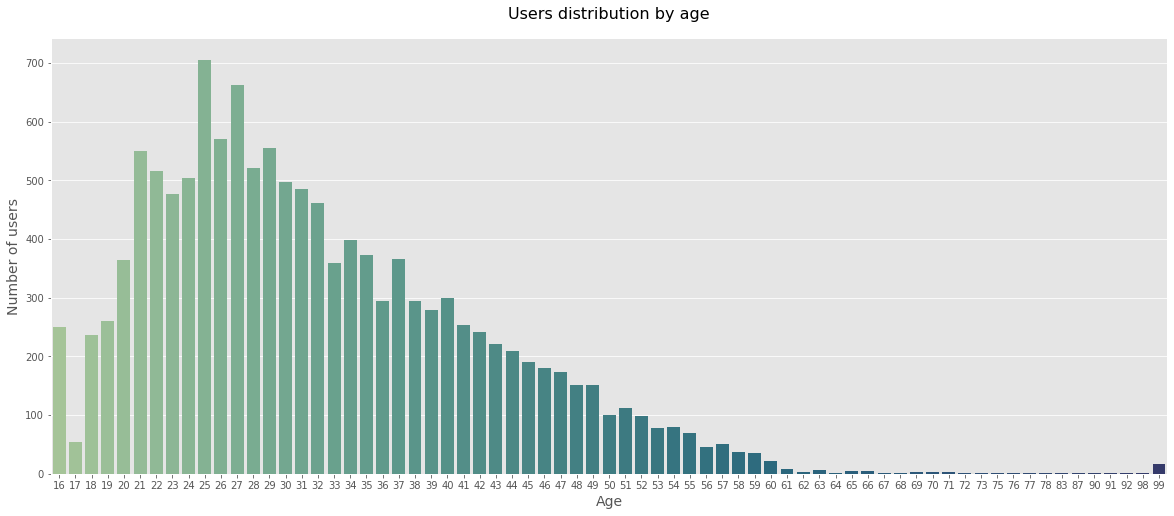

In [383]:
plt.figure(figsize = (20, 8))
ax = sns.countplot(data = users_info, x = 'age',  palette = "crest")
plt.xlabel("Age", size=14)
plt.ylabel("Number of users", size=14)
plt.title('Users distribution by age', pad = 20, size = 16)
sns.despine()

In [384]:
users_info.age.describe()

count    12912.000000
mean        32.010378
std         10.224415
min         16.000000
25%         25.000000
50%         30.000000
75%         38.000000
max         99.000000
Name: age, dtype: float64

#### Анализ аудитории по количеству посещений
- Создаем колонку, содержащую количество посещений приложения пользователем
- Строим график распределения количества пользователей по частоте посещения приложения

In [385]:
users_info['visit_days'] = users_info['visit_days'].fillna(0)

In [386]:
users_info['visits'] = users_info['visit_days'].apply(lambda x: len(str(x).split(',')) if x != 0 else 0)

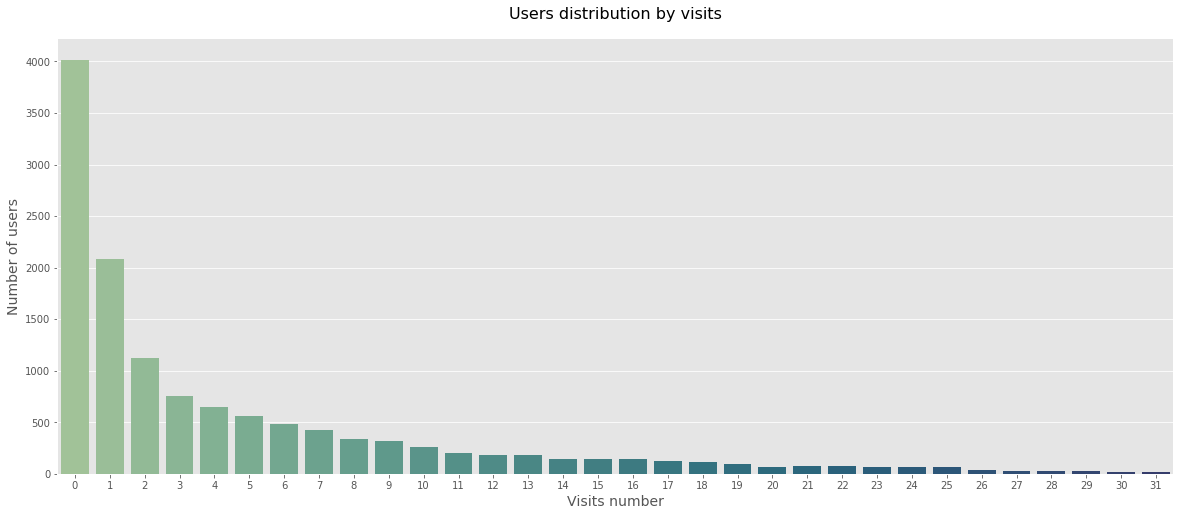

In [387]:
plt.figure(figsize = (20, 8))
ax = sns.countplot(data = users_info, x = 'visits', palette = "crest")
plt.xlabel("Visits number", size=14)
plt.ylabel("Number of users", size=14)
plt.title('Users distribution by visits', pad = 20, size = 16)
sns.despine()

In [388]:
users_info.visits.describe()

count    12912.00000
mean         4.55855
std          6.22509
min          0.00000
25%          0.00000
50%          2.00000
75%          7.00000
max         31.00000
Name: visits, dtype: float64

#### Анализ соотношения полов
После небольшого ресерча и статьи (https://habr.com/ru/company/vdsina/blog/490238/) о соотношении мужчин и женщин в дейтинговых приложениях, предполагаем, что обозначение пола следующее: male = 1, female = 0

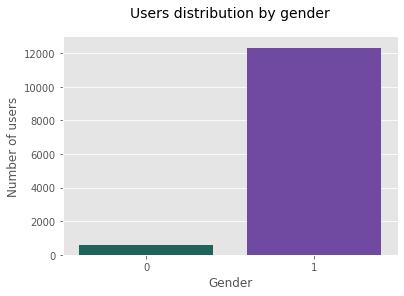

In [389]:
sns.countplot(data = users_info, x = 'gender', palette = ['#136f62' , '#6e3bb0'])
plt.xlabel("Gender", size=12)
plt.ylabel("Number of users", size=12)
plt.title('Users distribution by gender', pad = 20, size = 14)
sns.despine()

#### Разница,  между датой регистрации и первой датой оплаты подписки
- Создаем столбец, который будет содержать информацию о разнице между регистрацией пользователя и датой оплаты какого-либо продукта
- Строим графики распределения для сроков первой оплаты подписки в приложении

In [390]:
for data in [transactions_test, transactions_control_1, transactions_control_2]:
    data['weeks_until_payment'] = (data.paid_at - data.joined_at)
    data['weeks_until_payment'] = round(data['weeks_until_payment'].dt.days / 7)
    data['weeks_until_payment'] = data['weeks_until_payment'].fillna(0).astype('int')

In [391]:
# Для лучшего восприятия графиков зададим цвет каждой группе
group_colors = dict(test = '#05b655', cont_1 = '#1bb9ec', cont_2 = '#1b9cae')
group_palette = ['#1bb9ec','#1b9cae', '#05b655']

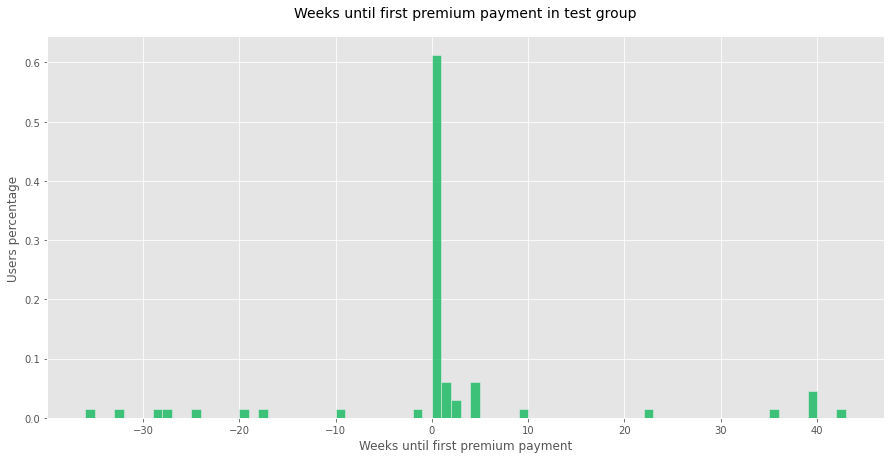

In [392]:
plt.figure(figsize = (15, 7))
sns.histplot(data = transactions_test \
             .query("product_type == ['premium', 'premium_no_trial']")
             .sort_values(['uid', 'paid_at']) \
             .drop_duplicates('uid'), \
             
             x = 'weeks_until_payment', \
             stat = 'probability', \
             binwidth = 1, \
             color = group_colors['test'])
plt.xlabel("Weeks until first premium payment", size=12)
plt.ylabel("Users percentage", size=12)
plt.title('Weeks until first premium payment in test group', pad = 20, size = 14)
sns.despine()

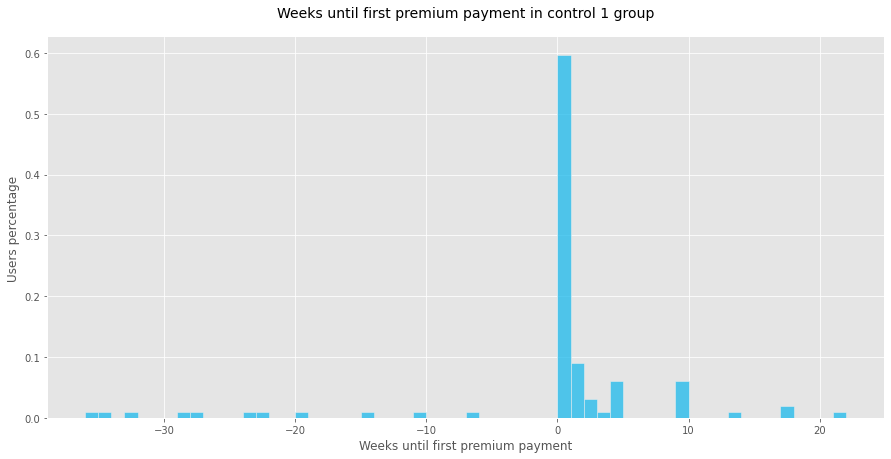

In [393]:
plt.figure(figsize = (15, 7))
sns.histplot(data = transactions_control_1 \
             .query("product_type == ['premium', 'premium_no_trial']")
             .sort_values(['uid', 'paid_at']) \
             .drop_duplicates('uid'), \
             x = 'weeks_until_payment', \
             stat = 'probability', \
             binwidth = 1, \
             color = group_colors['cont_1'] )
plt.xlabel("Weeks until first premium payment", size=12)
plt.ylabel("Users percentage", size=12)
plt.title('Weeks until first premium payment in control 1 group', pad = 20, size = 14)
sns.despine()

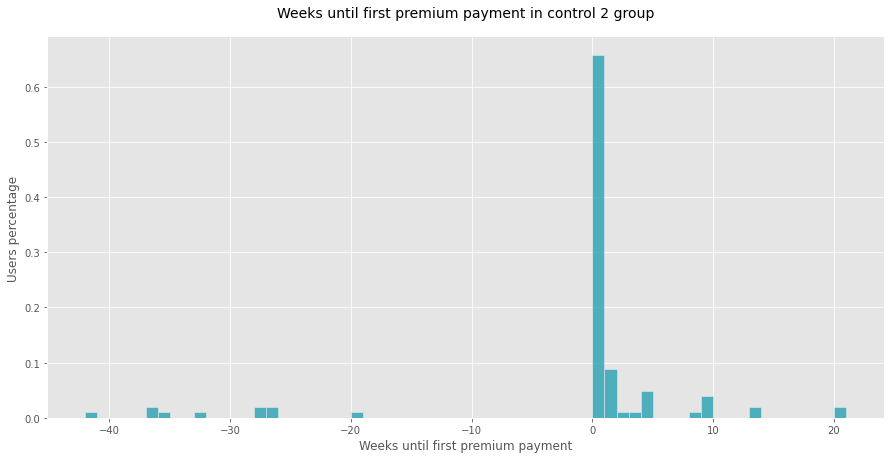

In [394]:
plt.figure(figsize = (15, 7))
sns.histplot(data = transactions_control_2 \
             .query("product_type == ['premium', 'premium_no_trial']")
             .sort_values(['uid', 'paid_at']) \
             .drop_duplicates('uid'), \
             x = 'weeks_until_payment', \
             stat = 'probability', \
             binwidth = 1, \
             color = group_colors['cont_2'])
plt.xlabel("Weeks until first premium payment", size=12)
plt.ylabel("Users percentage", size=12)
plt.title('Weeks until first premium payment in control 2 group', pad = 20, size = 14)
sns.despine()

1. Возможно, люди, у которых оплата подписки произошла раньше регистрации, получили подписку в подарок или участвовали в промоакции.  
2. Видим, что у пользователей, которые были в контрольных группах, похожее распределение на графиках.  
У пользователей первой группы достаточно симметричный разброс в правую и левую части.

### Анализ транзакций, дохода с пользователей и поиск ошибок в данных 

Объединеним датасеты по транзакциям и информации о пользователях:
1. Добавим в новый датафрейм столбец с названием группы (тестовая или контрольная)
2. Отберем столбцы, которые кажутся важными в анализе групп пользователей: **uid, age, gender, was_premium, is_premium, total_revenue, group, coins**

In [395]:
k = 0
group_names = ['test', 'control_1', 'control_2']
transactions_data = pd.DataFrame()
for users, transactions in zip((users_test, users_control_1, users_control_2), \
                               (transactions_test, transactions_control_1, transactions_control_2)):
    users['group'] = group_names[k]
    transactions_data = pd.concat( [transactions_data, \
                       transactions.merge(users[['uid', 'age', 'gender', 'was_premium', 'is_premium', 'total_revenue', 'group', 'coins']], \
                                          on = 'uid', how = 'left')]).reset_index(drop = True)
    k += 1

Убедимся, что total_revenue равен агреггированному доходу с пользователя по столбцу revenue:
- Агрегация по revenue
- Агрегация по total_revenue

In [396]:
transactions_data.groupby(['group', 'uid'], as_index = False).agg({'revenue': 'sum'}) \
                .groupby('group', as_index = False).agg({'revenue': 'median'})

,group,revenue
0,control_1,9490.0
1,control_2,7969.0
2,test,12727.0


In [397]:
transactions_data.sort_values(['paid_at'], ascending = False) \
        .drop_duplicates('uid').groupby('group', as_index = False).agg({'total_revenue': 'median'}) 

,group,total_revenue
0,control_1,9139
1,control_2,7969
2,test,12727


Посмотрим, где могла быть ошибка    

 - Выведем записи о пользователях, у которых агрегированное значение revenue не равно total_revenue
 - Значение from_page  в оплате пользователем 960936960.0 намекает на то, что был оформлен возврат денег (или деньги вернулись из-за проблем с оплатой).  
 - Убеждаемся, что в датасете записи с таким названием страницы уникальны.
 - Удаляем записи.


In [398]:
transactions_data.query('group == "control_1"').groupby('uid', as_index = False) \
                    .agg({'revenue': 'sum', 'total_revenue': 'max'}) \
                    .query('total_revenue != revenue')

,uid,revenue,total_revenue
181,892355163.0,30264.0,0
192,960936960.0,806.0,26


In [399]:
transactions_data.query('uid == 960936960.0')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,weeks_until_payment,age,gender,was_premium,is_premium,total_revenue,group,coins
338,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type,99,30,1,1.0,1.0,26,control_1,99958.0
374,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type,99,30,1,1.0,1.0,26,control_1,99958.0
497,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type,99,30,1,1.0,1.0,26,control_1,99958.0


In [400]:
transactions_data.query('from_page == ["refund_VP", "refung_AP", "refund_WP"]')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,weeks_until_payment,age,gender,was_premium,is_premium,total_revenue,group,coins
338,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type,99,30,1,1.0,1.0,26,control_1,99958.0
374,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type,99,30,1,1.0,1.0,26,control_1,99958.0
497,960936960.0,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type,99,30,1,1.0,1.0,26,control_1,99958.0


In [401]:
transactions_data = transactions_data \
                    .drop(transactions_data.query('from_page == ["refund_VP", "refung_AP", "refund_WP"]') \
                    .index)

Во втором случае скорее всего произошла ошибка при записи данных, поэтому просто заменяем значение по столбцу total_revenue для пользователя

In [402]:
transactions_data.query('uid == 892355163.0')

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,weeks_until_payment,age,gender,was_premium,is_premium,total_revenue,group,coins
576,892355163.0,United States of America,2017-10-15 18:45:00,2017-10-16 09:52:00,30264.0,68.0,super_popup,other_type,0,40,1,1.0,0.0,0,control_1,0.0


In [403]:
transactions_data.loc[transactions_data['uid'] == 892355163.0, 'total_revenue'] = 30264.0

Чтобы понимать, какую роль может играть страница, с которой пользователь перешел для оплаты, сделаем преобразование таблицы с транзакциями.  
По всем типам страницы, кроме none и fans наблюдается следующая картина: пользователи либо платили за премиум подписку (или ее пробную версию), либо тип продукта other_type и coins.   
Используем это при дальнейшем анализе.


In [404]:
# Страницы, переход с которых закончился оплатой trial_premium или premium_no_trial
transactions_data.groupby(['product_type', 'from_page'], as_index = False) \
                .agg({'uid': 'count'}) \
                .pivot(index = 'from_page', columns = 'product_type', values = 'uid') \
                .fillna(0) \
                .query('premium_no_trial > 0 or trial_premium > 0')

product_type,coins,other_type,premium_no_trial,trial_premium
from_page,,,,
autoreply_message,0.0,0.0,67.0,13.0
dating,0.0,0.0,18.0,6.0
delivery_vip,0.0,0.0,1.0,0.0
fans,5.0,6.0,4.0,0.0
left_sidebar_menu,0.0,0.0,45.0,2.0
no_sympathy,0.0,0.0,2.0,0.0
none,39.0,5.0,53.0,3.0
popular_users_block,0.0,0.0,18.0,1.0
popular_users_chat,0.0,0.0,13.0,2.0


In [405]:
# Страницы, переход с которых закончился оплатой coins или other type
transactions_data.groupby(['product_type', 'from_page'], as_index = False) \
                .agg({'uid': 'count'}) \
                .pivot(index = 'from_page', columns = 'product_type', values = 'uid') \
                .fillna(0) \
                .query('coins > 0 or other_type > 0')

product_type,coins,other_type,premium_no_trial,trial_premium
from_page,,,,
ad_to_photo,7.0,3.0,0.0,0.0
admins,0.0,2.0,0.0,0.0
autorefill,48.0,0.0,0.0,0.0
coins_popup,0.0,3.0,0.0,0.0
empty_admins,0.0,5.0,0.0,0.0
empty_likes,212.0,60.0,0.0,0.0
empty_mutual,0.0,2.0,0.0,0.0
fans,5.0,6.0,4.0,0.0
gifts,16.0,4.0,0.0,0.0


### Распределение дохода с пользователя в разных группах
1. Создаем датасет с информацией о доходе с пользователя
2. Строим графики и смотрим на описательную статистику
3. Разбираемся в выбросах

In [406]:
revenue_per_user = transactions_data.drop_duplicates('uid') \
                    .drop(columns = ['paid_at', 'payment_id', 'from_page', 'product_type'])

In [407]:
revenue_per_user.head()

,uid,country,joined_at,revenue,weeks_until_payment,age,gender,was_premium,is_premium,total_revenue,group,coins
0,891345942.0,Italy,2017-05-11 13:00:00,12909.0,27,52,1,1.0,1.0,12909.0,test,0.0
1,892054251.0,United States of America,2017-10-22 00:33:00,13923.0,1,37,1,1.0,1.0,13923.0,test,0.0
2,892236423.0,United States of America,2017-10-18 01:09:00,3783.0,1,23,1,1.0,1.0,95823.0,test,378.0
4,892168170.0,United States of America,2017-10-19 17:10:00,9087.0,1,29,1,1.0,1.0,15392.0,test,4.0
5,892426491.0,United States of America,2017-10-14 10:13:00,12597.0,0,48,1,1.0,0.0,12597.0,test,0.0


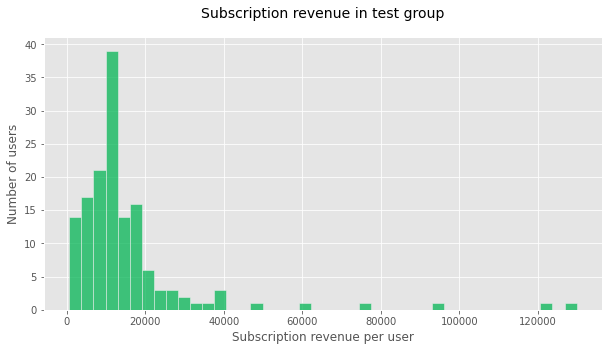

In [408]:
plt.figure(figsize = (10, 5))
sns.histplot(data = revenue_per_user[revenue_per_user.group == 'test'],\
             x = 'total_revenue', \
             color = group_colors['test'])
plt.xlabel("Subscription revenue per user", size=12)
plt.ylabel("Number of users", size=12)
plt.title('Subscription revenue in test group', pad = 20, size = 14)
sns.despine()

In [409]:
revenue_per_user[revenue_per_user.group == 'test'].total_revenue.describe()

count       146.000000
mean      15759.027397
std       18058.118399
min         624.000000
25%        8248.500000
50%       12727.000000
75%       16428.750000
max      129870.000000
Name: total_revenue, dtype: float64

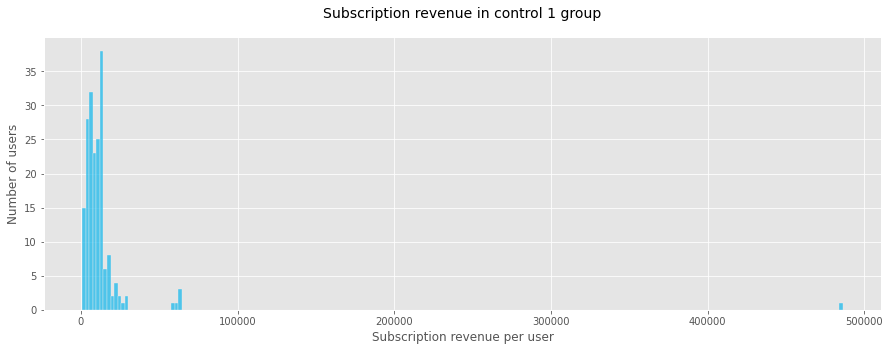

In [410]:
plt.figure(figsize = (15, 5))
sns.histplot(data = revenue_per_user[revenue_per_user.group == 'control_1'], \
             x = 'total_revenue', \
             color = group_colors['cont_1'])
plt.xlabel("Subscription revenue per user", size=12)
plt.ylabel("Number of users", size=12)
plt.title('Subscription revenue in control 1 group', pad = 20, size = 14)
sns.despine()

In [411]:
revenue_per_user[revenue_per_user.group == 'control_1'].total_revenue.describe()

count       192.000000
mean      13601.588542
std       35726.471481
min         728.000000
25%        6292.000000
50%        9639.500000
75%       12889.500000
max      486330.000000
Name: total_revenue, dtype: float64

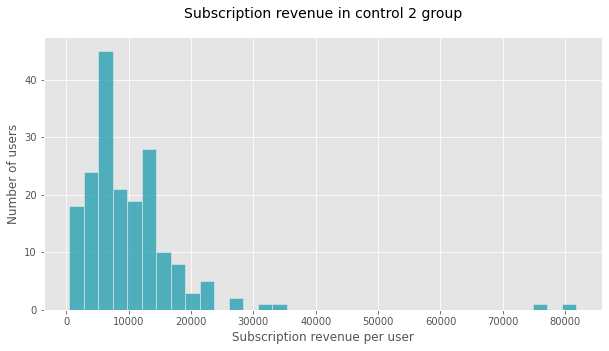

In [412]:
plt.figure(figsize = (10, 5))
sns.histplot(data = revenue_per_user[revenue_per_user.group == 'control_2'], x = 'total_revenue', color = group_colors['cont_2'])
plt.xlabel("Subscription revenue per user", size=12)
plt.ylabel("Number of users", size=12)
plt.title('Subscription revenue in control 2 group', pad = 20, size = 14)
sns.despine()

In [413]:
revenue_per_user[revenue_per_user.group == 'control_2'].total_revenue.describe()

count      187.000000
mean     10269.721925
std       9272.960475
min        481.000000
25%       6064.500000
50%       7969.000000
75%      12727.000000
max      81796.000000
Name: total_revenue, dtype: float64

### Дубликаты и выбросы

Необходимо понять природу сильных выбросов (в особенности в первой контрольной группе) для предупреждения ошибок при проведении статистического анализа.

- Смотрим на записи в группе control_1, которые привели к наличию сильных выбросов
- Убеждаемся, что на наличие 'этих выбросов повлиял один уникальный пользователь

In [414]:
transactions_data[transactions_data.total_revenue > 400000].sort_values('paid_at').head()

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,weeks_until_payment,age,gender,was_premium,is_premium,total_revenue,group,coins
322,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:42:00,3783.0,67.0,menu,other_type,0,22,1,1.0,1.0,486330.0,control_1,3608.0
286,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type,0,22,1,1.0,1.0,486330.0,control_1,3608.0
320,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type,0,22,1,1.0,1.0,486330.0,control_1,3608.0
442,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:44:00,3783.0,67.0,menu,other_type,0,22,1,1.0,1.0,486330.0,control_1,3608.0
301,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 01:57:00,3783.0,67.0,empty_admins,other_type,0,22,1,1.0,1.0,486330.0,control_1,3608.0


In [415]:
transactions_data[transactions_data.total_revenue > 400000].uid.nunique()

1

- Посмотрим, есть ли дубликаты, которые могли возникнуть по ошибке при записи данных.  
- Ищем записи, которые совпадают по параметрам **paid_at, revenue, payment_id, from_page, product_type,** поскольку это будет свидетельствовать о возможной ошибке при записи в данных.  
- Видим, что даже для этого пользователя такие записи есть ( только 19 строк из 27, приходящиеся на данного пользователя, уникальные).   
- Имеет смысл пройтись по всему набору данных и удалить подобные дубликаты.

In [416]:
transactions_data.query('uid == 892333905.0') \
                .groupby(['paid_at', 'revenue', 'payment_id','from_page','product_type']) \
                .agg({'uid': 'count'}).shape[0]

19

In [417]:
transactions_data[transactions_data.total_revenue > 400000].shape[0]

27

In [418]:
transactions_data = transactions_data.drop_duplicates(['uid', 'paid_at', 'revenue', 'from_page', 'payment_id', 'product_type'])

- После удаления дубликатов создаем датасет **bags_revenue**, в котором будут записи о все пользователях, значение агрегированного revenue для которых не совпадает с total_revenue.  
- Проходимся по этому датасету и для всех попавших в него uid меняем значение total_revenue в датасете transactions_data.

In [419]:
bags_revenue = transactions_data.groupby('uid', as_index = False) \
                    .agg({'revenue': 'sum', 'total_revenue': 'max', 'group': 'max'}) \
                    .query('total_revenue != revenue')
bags_revenue.head()

,uid,revenue,total_revenue,group
47,891252072.0,7553.0,8814.0,control_1
89,891320916.0,10075.0,13858.0,control_1
110,891365490.0,8814.0,10075.0,control_1
114,891367521.0,16081.0,20462.0,control_1
137,891452706.0,12597.0,18902.0,control_1


In [420]:
for uid in bags_revenue['uid']:
    transactions_data.loc[transactions_data['uid'] == uid, 'total_revenue'] = \
    float(bags_revenue[bags_revenue.uid == uid]['revenue'])
revenue_per_user = transactions_data.drop_duplicates('uid')

Учитываем, что проблема может быть не только в наличии дубликатов, посмотрим в какие даты пользователь uid = 892333905.0 совершал покупки.  
Видим, что 15 раз пользователь оплачивал покупки 16.10.2017 - в день своей регистрации в приложении.

In [421]:
transactions_data[transactions_data.total_revenue > 400000].paid_at.dt.date.value_counts()

2017-10-16    15
2017-10-17     4
Name: paid_at, dtype: int64

**Причины для удаления записей о пользователе:**
 - Человек проявлял подозрительную активность только в первые 2 суток регистрации
 - Он является единственным пользователем, который стал причиной экстремально сильных выбросов не только среди пользователей первой контрольной группы, но и всех пользователей в целом
 - По результатам графиков в разделе анализа аудитории видим, что из Италии около 1000 пользователей, но такое поведение ни у кого больше не наблюдается
 - Не совсем понятно, что послужило причиной такому поведению
 - Пользователь расплачивался преимущественно внутренней валютой
 - Нельзя сделать вывод, какие записи о пользователе можно оставить (человек мог просто тестировать все возможностит взаимодействия в приложении за внутреннюю валюту)
 
 Удаляем записи и строим новый график распределения для контрольной группы 2

In [422]:
transactions_data = transactions_data.query('uid != 892333905.0')

In [423]:
# Обновим датасет revenue_per_user, он зависел от transactions_data
revenue_per_user = transactions_data.drop_duplicates('uid')

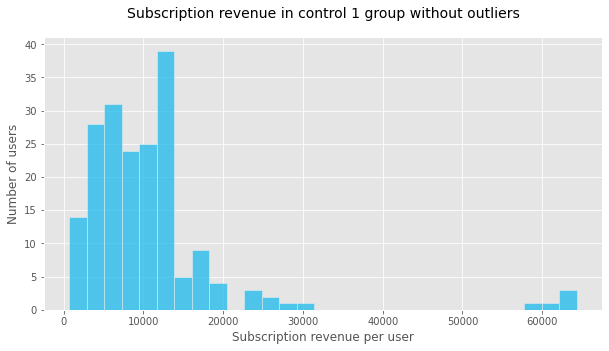

In [424]:
plt.figure(figsize = (10, 5))
sns.histplot(data = revenue_per_user[revenue_per_user.group == 'control_1'], \
             x = 'total_revenue', \
             color = group_colors['cont_1'])
plt.xlabel("Subscription revenue per user", size=12)
plt.ylabel("Number of users", size=12)
plt.title('Subscription revenue in control 1 group without outliers', pad = 20, size = 14)
sns.despine()

**Проанализируем выбросы total revenue в тестовой группе**
 - Посмотрим на записи о покупках, которые возможно стали причиной таких больших значений по полю total_revenue
 - По полю product_type	видим, что пользователи оформляли премиум подписку и заплатили одинаковую сумму
 - Даты оплаты разные, оставляем записи об этих пользователях, поскольку ничего подозрительного в записях не обнаружено

In [425]:
transactions_data.query('group == "test"') \
                [transactions_data.total_revenue > 120000] \
                .sort_values('revenue', ascending = False) \
                .drop_duplicates('uid')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,weeks_until_payment,age,gender,was_premium,is_premium,total_revenue,group,coins
12,891178380.0,Spain,2017-08-11 03:54:00,2017-09-11 21:53:00,113477.0,147.0,promo_09,premium_no_trial,4,42,1,1.0,1.0,129870.0,test,85.0
196,892038759.0,United Arab Emirates,2017-10-22 11:12:00,2017-10-22 16:23:00,113477.0,147.0,autoreply_message,premium_no_trial,0,26,1,1.0,1.0,123565.0,test,3.0


- Похожие записи обнаруживаем во второй контрольной группе  

In [426]:
transactions_data.query('group == "control_2"') \
                [transactions_data.total_revenue > 70000] \
                .sort_values(['uid','revenue'], ascending = False) \
                .drop_duplicates('uid')

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,weeks_until_payment,age,gender,was_premium,is_premium,total_revenue,group,coins
672,892307238.0,Spain,2017-10-16 16:01:00,2017-10-16 20:41:00,63037.0,147.0,left_sidebar_menu,premium_no_trial,0,29,1,1.0,1.0,75647.0,control_2,43.0
697,891778551.0,United Arab Emirates,2017-10-27 21:26:00,2017-10-27 22:30:00,81796.0,147.0,left_sidebar_menu,premium_no_trial,0,30,1,1.0,1.0,81796.0,control_2,0.0


Почему доход от некоторых пользователей по премиум подписке настолько сильно отличается, утверждать нельзя.
Если в приложении есть опция оплаты за год пользования, пользователи могли ею воспользоваться.

## A/A тест
Чтобы проверить качество системы сплитования трафика и убедиться, что статистически значимые различия не будут возникать из-за технических проблем, проведем А/А тесты на метриках:
1. Доход от транзакции
2. Наличие премиум подписки

Напишем функцию для А/А теста.  
Количество значений в выборках будет определеляться процентами (значение n_s).  

Количество симуляций и значений в выборках подбираем эмпирически.

**H0 для t-теста, реализуемого в функции** - средние в выборках не имеют статистически значимых различий 

In [427]:
def aa_test_revenue(data, column, n_perc, sim):
    n_s = int(n_perc * data.shape[0])
    res = []
    for s in range(sim):
        sample1 = data[column].sample(n_s, replace = False).values
        sample2 = data[column].sample(n_s, replace = False).values
        res.append(stats.ttest_ind(sample1, sample2, equal_var = False)[1])
    
    plt.hist(res, bins = 50)
    plt.style.use('ggplot')
    plt.xlabel('pvalues')
    plt.ylabel('frequency')
    plt.title(f"Histogram of A/A ttest simulations for {column} samples")
    plt.show()
    
    print(f'FPR(p < 0.05) = {sum(np.array(res) <0.05) / sim}','\n',
          f'FPR(p < 0.1) = {sum(np.array(res) <0.1) / sim}')
    

**Применяем функцию для тестовой группы:**
1. Доход
2. Наличие подписки

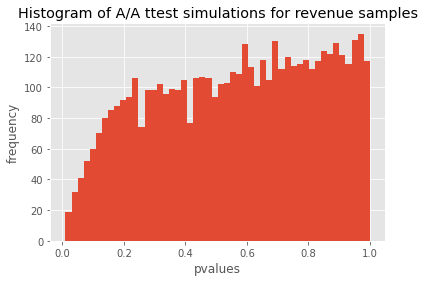

FPR(p < 0.05) = 0.0106 
 FPR(p < 0.1) = 0.036


In [428]:
aa_test_revenue(transactions_test, 'revenue', 0.4, 5000)

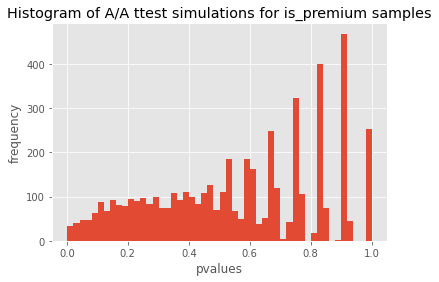

FPR(p < 0.05) = 0.0188 
 FPR(p < 0.1) = 0.0464


In [429]:
aa_test_revenue(users_test, 'is_premium', 0.3, 5000)

**Первая контрольная группа**
1. Доход
2. Наличие подписки

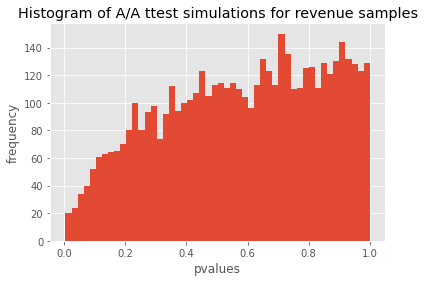

FPR(p < 0.05) = 0.0112 
 FPR(p < 0.1) = 0.0314


In [430]:
aa_test_revenue(transactions_control_1, 'revenue',  0.4, 5000)

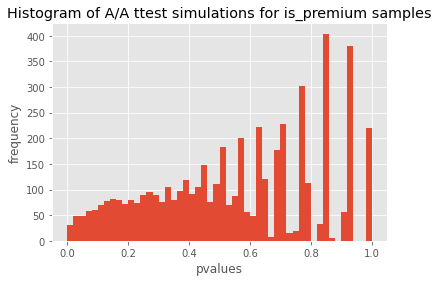

FPR(p < 0.05) = 0.0208 
 FPR(p < 0.1) = 0.0488


In [431]:
aa_test_revenue(users_control_1, 'is_premium', 0.3, 5000)

**Вторая контрольная группа**
1. Доход
2. Наличие подписки

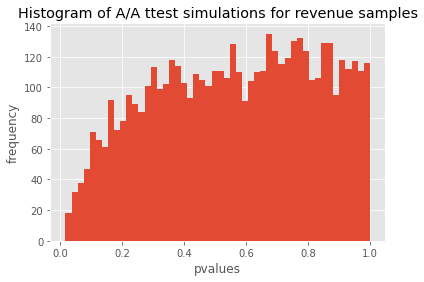

FPR(p < 0.05) = 0.0082 
 FPR(p < 0.1) = 0.0302


In [432]:
aa_test_revenue(transactions_control_2, 'revenue',  0.4, 5000)

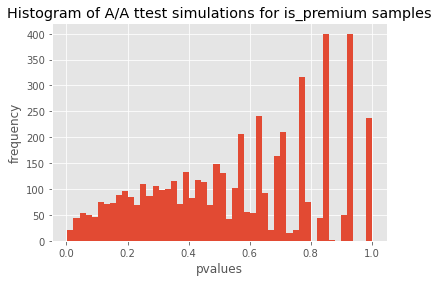

FPR(p < 0.05) = 0.019 
 FPR(p < 0.1) = 0.0416


In [433]:
aa_test_revenue(users_control_2, 'is_premium', 0.3, 5000)

**Вывод:**  
Система сплитования не сломана и можно проводить А/В тест.

## Статистический анализ A/B теста

Поскольку был проведен А/В тест, в котором для новых пользователей из нескольких стран была изменена стоимость премиум-подписки, проверим:
1. Есть ли значимые различия в доходе с пользователей
2. Есть ли значимые различия в доходе с оплаты подписки и пробной подписки 
2. Есть ли значимые различия в частоте продления подписок одним пользователем
3. Есть ли значимые различия между группами в соотношении числа пользователей, оформивших и неоформивших подписку
4. Влияет ли на наличие подписки то, была ли у пользователя премиум-подписка ранее
5. Есть ли различия в доходе между какими-либо группами пользователей

Метрики, которые будем использовать:
1. revenue
2. total_revenue
3. is_premium
4. payment_frequency

### Различия в доходе с пользователя



Посмотрим на средний общий доход с пользователя в группах:

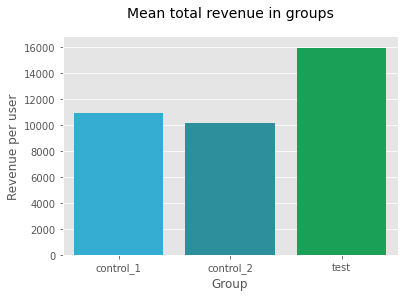

In [434]:
sns.barplot(data = transactions_data \
            .sort_values('paid_at', ascending = False) \
            .drop_duplicates('uid') \
            .groupby('group', as_index = False).agg({'total_revenue': 'mean'}), \
            x = 'group', y = 'total_revenue', palette = group_palette)
plt.xlabel("Group", size=12)
plt.ylabel("Revenue per user", size=12)
plt.title('Mean total revenue in groups', pad = 20, size = 14)
sns.despine()

Средний доход с транзакций:

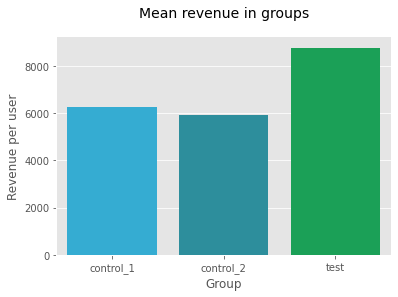

In [435]:
sns.barplot(data = transactions_data \
            .groupby('group', as_index = False).agg({'revenue': 'mean'}), \
            x = 'group', y = 'revenue', palette = group_palette)
plt.xlabel("Group", size=12)
plt.ylabel("Revenue per user", size=12)
plt.title('Mean revenue in groups', pad = 20, size = 14)
sns.despine()

Визуализируем данные при помощи боксплота

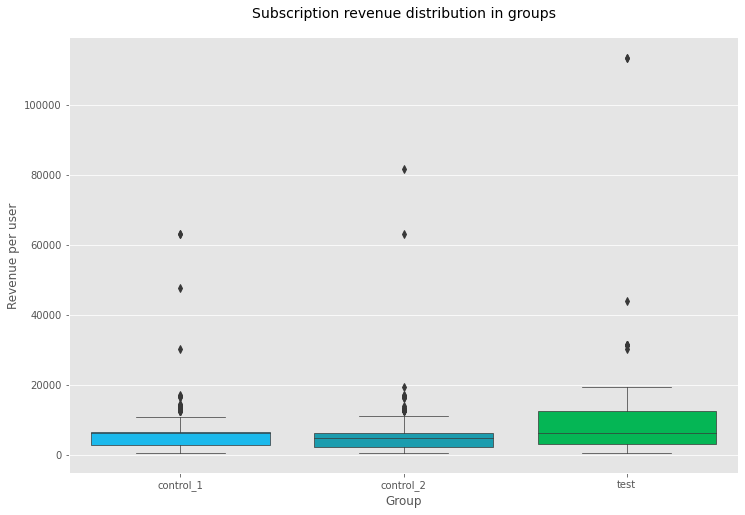

In [436]:
plt.figure(figsize= (12, 8))
sns.boxplot(x = 'group', \
            y = 'revenue', \
            data = transactions_data.sort_values('group'), \
            palette = group_palette, \
            saturation = 1,\
            linewidth = 0.7)
plt.xlabel("Group", size=12)
plt.ylabel("Revenue per user", size=12)
plt.title('Subscription revenue distribution in groups', pad = 20, size = 14)
sns.despine()

### 1. ANOVA по метрике revenue

Проверка выборок на нормальность.  
**H0** - выборка взята из генеральной совокупности, в которой значения распределены нормально  
**Результат** - распределения в выборках значимо отличаются от нормального.

In [437]:
for group in group_names:
    print(group, 'p-value:', '\t', stats.shapiro(transactions_data[transactions_data.group == group]['revenue'])[1])

test p-value: 	 8.011712953511395e-27
control_1 p-value: 	 1.5151389094921548e-27
control_2 p-value: 	 1.7662834723952801e-28


Проверим выборки на гомогенность дисперсии  
**H0** - выборки взяты из генеральных совокупностей с одинаковыми дисперсиями  
**Результат** - дисперсии в группах значимо различаются 

In [438]:
stats.levene(transactions_data[transactions_data.group == 'test']['revenue'], \
             transactions_data[transactions_data.group == 'control_1']['revenue'], \
             transactions_data[transactions_data.group == 'control_2']['revenue'])

LeveneResult(statistic=9.27512647071466, pvalue=0.0001027865486733401)

ANOVA Уэлча для условия разных дисперсий  

**H0** - ни одно из средних значений в выборках не отличается от других  
**Результат** - среднее хотя бы в одной группе значимо отличается от других

In [439]:
pg.welch_anova(data = transactions_data, dv = 'revenue', between = 'group' )

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,550.147275,6.894611,0.001103,0.02218


Тест Геймса-Хоувелла для попарного сравнения групп при условии разных дисперсий  

**H0** - средние значения в группах значимо не отличаются   
**Результат** - есть значимые различия между тестовой и контрольными группами

In [440]:
pg.pairwise_gameshowell(data = transactions_data, dv = 'revenue', between = 'group' )

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,control_1,control_2,6260.161677,5907.111455,353.050222,506.623491,0.696869,651.574844,0.745199,0.054320
1,control_1,test,6260.161677,8767.766917,-2507.605241,770.800051,-3.253250,397.437726,0.003541,-0.267014
2,control_2,test,5907.111455,8767.766917,-2860.655462,780.018520,-3.667420,410.826434,0.001000,-0.303264


Дополнительно используем критерий Манна-Уитни для сравнения средних в группах  

**H0 для каждого теста** - распределения в выборках значимо не отличаются   

Тест + контроль 1

In [441]:
stats.mannwhitneyu(transactions_data[transactions_data.group == 'test']['revenue'], \
             transactions_data[transactions_data.group == 'control_1']['revenue'])

MannwhitneyuResult(statistic=51622.0, pvalue=0.0006365874799595455)

Тест + контроль 2

In [442]:
stats.mannwhitneyu(transactions_data[transactions_data.group == 'test']['revenue'], \
             transactions_data[transactions_data.group == 'control_2']['revenue'])

MannwhitneyuResult(statistic=51698.0, pvalue=2.0938846344776575e-05)

Контроль 1 + Контроль 2

In [443]:
stats.mannwhitneyu(transactions_data[transactions_data.group == 'control_2']['revenue'], \
             transactions_data[transactions_data.group == 'control_1']['revenue'])

MannwhitneyuResult(statistic=50657.0, pvalue=0.1760796278296194)

**Результат** - есть значимые различия между тестовой и обеими контрольными группами

### 2. Критерий Хи-квадрат независимости метрики is_premium от группы

Проверим различия в распределении количества пользователей с подпиской и без в разных группах.  
Для этого используем критерий Хи-квадрат и таблицы сопряженности.
Порядок действий:
- Строим таблицу сопряженности
- Проводим тест

**H0** - количество пользователей, оформивших и не оформивших подписку не зависит от группы, распределение равномерно.

In [444]:
pd.crosstab(users_info.group, users_info.is_premium)

is_premium,0.0,1.0
group,,
control_1,4148,192
control_2,4073,191
test,4151,157


In [445]:
stats.chi2_contingency(pd.crosstab(users_info.group, users_info.is_premium))

(4.682218872475243,
 0.09622082811841565,
 2,
 array([[4158.49442379,  181.50557621],
        [4085.67286245,  178.32713755],
        [4127.83271375,  180.16728625]]))

**Результат** - Не видим статистически значимых различий в соотношении числа оформивших и не оформивших подписку пользователей между сравниваемыми группами

Проведем тот же тест попарно.  
**H0 для каждого теста** - количество пользователей, оформивших и не оформивших подписку не зависит от группы, распределение равномерно.

Тест + контроль 1

In [446]:
stats.chi2_contingency(pd.crosstab(users_info.query('group != "control_2"').group, \
                        users_info.is_premium))

(3.1944377604342717,
 0.07388917354047164,
 1,
 array([[4164.85430157,  175.14569843],
        [4134.14569843,  173.85430157]]))

Тест + контроль 2

In [447]:
stats.chi2_contingency(pd.crosstab(users_info.query('group != "control_1"').group, \
                        users_info.is_premium))

(3.624492947571289,
 0.056934918926926356,
 1,
 array([[4090.89314046,  173.10685954],
        [4133.10685954,  174.89314046]]))

Контроль 1 + контроль 2

In [448]:
stats.chi2_contingency(pd.crosstab(users_info.query('group != "test"').group, \
                        users_info.is_premium))

(0.005227619694682702,
 0.942361350261814,
 1,
 array([[4146.80846118,  193.19153882],
        [4074.19153882,  189.80846118]]))

**Результат** - вероятность получить такие или еще более выраженные различия между тестовой и обеими контрольными группами по исследуемому признаку очень маленькая, но значения p-value >= 0.05 в обоих случаях не позволяют нам отклонить H0.  
С другой стороны видим, что p-value для среза контроль 1 + контроль 2 в разы больше.

### 3. Критерий Хи-квадрат независимости метрики is_premium от метрики was_premium

Проверим различия в соотношении числа оформивших и не оформивших подписку пользователей между теми, у кого подписка была и и теми, кто ее ранее не оформлял.  
**H0 для каждого теста** - количество пользователей, оформивших и не оформивших подписку не зависит от того, была ли у пользователя подписка ранее.

**Тестовая группа:**

In [449]:
pd.crosstab(users_test.was_premium, users_test.is_premium)

is_premium,0.0,1.0
was_premium,,
0.0,3900,0
1.0,251,157


In [450]:
stats.chi2_contingency(pd.crosstab(users_test.was_premium, users_test.is_premium))

(1546.5575150564396,
 0.0,
 1,
 array([[3757.86908078,  142.13091922],
        [ 393.13091922,   14.86908078]]))

**Первая контрольная группа:**

In [451]:
pd.crosstab(users_control_1.was_premium, users_control_1.is_premium)

is_premium,0.0,1.0
was_premium,,
0.0,3904,0
1.0,244,192


In [452]:
stats.chi2_contingency(pd.crosstab(users_control_1.was_premium, users_control_1.is_premium))

(1788.3697595718954,
 0.0,
 1,
 array([[3731.28847926,  172.71152074],
        [ 416.71152074,   19.28847926]]))

**Вторая контрольная группа:**

In [453]:
pd.crosstab(users_control_2.was_premium, users_control_2.is_premium)

is_premium,0.0,1.0
was_premium,,
0.0,3853,0
1.0,220,191


In [454]:
stats.chi2_contingency(pd.crosstab(users_control_2.was_premium, users_control_2.is_premium))

(1863.688603049368,
 0.0,
 1,
 array([[3680.41017824,  172.58982176],
        [ 392.58982176,   18.41017824]]))

**Результат** - Количество пользователей, оформивших и не оформивших подписку во всех 3-х группах зависит от того, была ли у пользователя подписка ранее.

### 4. ANOVA по метрике revenue (доход от премиум подписки)

- Создаем датасет, в который входят только записи об оплате премиальной или пробной подписки
- Так как доход с пользователей идет не только с оплаты премиум подписки (можно предположить это по различии в названиях страниц, с которых переходят пользователи), пересчитаем доход, который получен за премиум подписку

In [455]:
user_revenue_premium = transactions_data.query("product_type == ['premium_no_trial', 'trial_premiun']") \
                        .groupby(['uid', 'country', 'age', 'gender', 'was_premium', 'is_premium', 'group'], as_index = False) \
                        .agg({'revenue': 'sum', 'paid_at': 'count', 'weeks_until_payment': 'min'}) \
                        .rename(columns ={'paid_at': 'payment_frequency'})
user_revenue_premium.head()

,uid,country,age,gender,was_premium,is_premium,group,revenue,payment_frequency,weeks_until_payment
0,891068079.0,Argentina,29,1,1.0,1.0,control_2,6292.0,1,9
1,891071157.0,United States of America,22,1,1.0,1.0,test,9100.0,1,0
2,891077727.0,Argentina,20,1,1.0,1.0,control_2,6292.0,1,0
3,891092322.0,Argentina,24,1,1.0,1.0,control_1,5278.0,1,4
4,891112263.0,United States of America,23,1,1.0,1.0,control_2,4680.0,1,9


Визуализируем данные при помощи боксплота

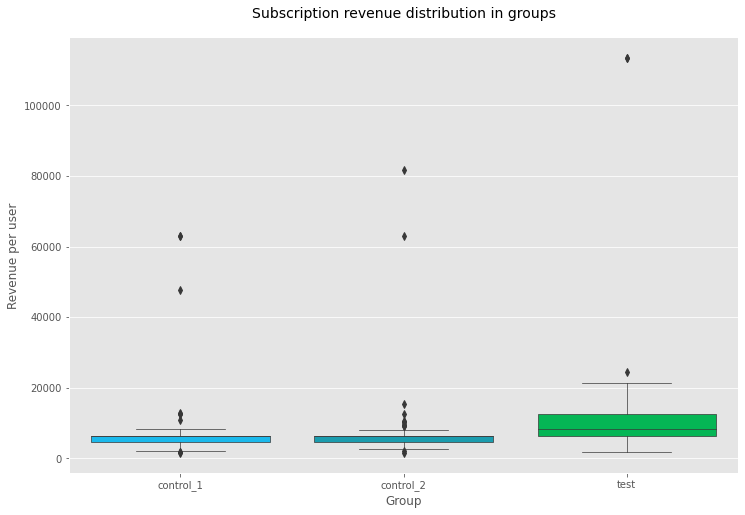

In [456]:
plt.figure(figsize= (12, 8))
sns.boxplot(x = 'group', \
            y = 'revenue', \
            data = user_revenue_premium.sort_values('group'), \
            palette = group_palette, \
            saturation = 1,\
            linewidth = 0.7)
plt.xlabel("Group", size=12)
plt.ylabel("Revenue per user", size=12)
plt.title('Subscription revenue distribution in groups', pad = 20, size = 14)
sns.despine()

Проверка выборок на нормальность.  
**H0** - выборка взята из генеральной совокупности, в которой значения распределены нормально  
**Результат** - распределения в выборках значимо отличаются от нормального.

In [457]:
for group in group_names:
    print(group, 'p-value:', '\t', stats.shapiro(user_revenue_premium[user_revenue_premium.group == group]['revenue'])[1])

test p-value: 	 7.250171629880487e-16
control_1 p-value: 	 3.157632224462589e-19
control_2 p-value: 	 2.8234107380658477e-20


Проверка на гомогенность дисперсии  
**H0** - выборки взяты из генеральных совокупностей с одинаковыми дисперсиями  
**Результат** - дисперсии в группах значимо не различаются 

In [458]:
stats.levene(user_revenue_premium[user_revenue_premium.group == 'test']['revenue'], \
             user_revenue_premium[user_revenue_premium.group == 'control_1']['revenue'], \
             user_revenue_premium[user_revenue_premium.group == 'control_2']['revenue'])

LeveneResult(statistic=2.0805596979787646, pvalue=0.12690287084568533)

Поскольку распределения статистически значимо отличаются от нормальных, для дисперсионного анализа используем непараметрический аналог ANOVA - критерий Краскела-Уоллиса.  

**H0** - ни одно из средних значений в выборках не отличается от других  
**Результат** - среднее хотя бы в одной группе значимо отличается от других

In [459]:
stats.kruskal(user_revenue_premium[user_revenue_premium.group == 'test']['revenue'], \
             user_revenue_premium[user_revenue_premium.group == 'control_1']['revenue'], \
             user_revenue_premium[user_revenue_premium.group == 'control_2']['revenue'])

KruskalResult(statistic=37.37623968308333, pvalue=7.653369400681474e-09)

Проведем попарные сравнения при помощи критерия Тьюки.  
**H0** - средние значения в группах значимо не отличаются   
**Результат** - есть значимые различия между тестовой и контрольными группами. В тестовой группе среднее значение дохода с пользователя больше.  

In [460]:
pg.pairwise_tukey(data = user_revenue_premium, dv = 'revenue', between = 'group' )

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,control_1,control_2,7308.387755,7302.049020,6.338735,1739.706572,0.003644,0.900000,0.000513
1,control_1,test,7308.387755,12100.089552,-4791.701797,1949.690443,-2.457673,0.038741,-0.387802
2,control_2,test,7302.049020,12100.089552,-4798.040533,1934.104766,-2.480755,0.036484,-0.388358


Используем критерий Манна-Уитни, чтобы еще раз посмотреть на различия между группами при попарном сравнении.  
**H0 для каждого теста** - распределения в выборках значимо не отличаются   

Тест + контроль 1

In [461]:
stats.mannwhitneyu(user_revenue_premium[user_revenue_premium.group == 'test']['revenue'], \
             user_revenue_premium[user_revenue_premium.group == 'control_1']['revenue'])

MannwhitneyuResult(statistic=4947.5, pvalue=2.5446059337130588e-08)

Тест + контроль 2

In [462]:
stats.mannwhitneyu(user_revenue_premium[user_revenue_premium.group == 'test']['revenue'], \
             user_revenue_premium[user_revenue_premium.group == 'control_2']['revenue'])

MannwhitneyuResult(statistic=5034.5, pvalue=1.5494296303089133e-07)

Контроль 1 + контроль 2

In [463]:
stats.mannwhitneyu(user_revenue_premium[user_revenue_premium.group == 'control_1']['revenue'], \
             user_revenue_premium[user_revenue_premium.group == 'control_2']['revenue'])

MannwhitneyuResult(statistic=4747.5, pvalue=0.529541048802848)

### Различия в частоте продления подписок

Необходимо проверить, есть ли различия в частоте оплаты подписок, поскольку если их нет, значит, доход с пользователя увеличился только за счет увеличения стоимости подписок.

1. Построим барплот распределения частоты оформления подписок одним пользователем.
2. Посмотрим на диапазон дат, за который есть данные по транзакциям.
3. Строим график динамики регистрации за весь период времени.

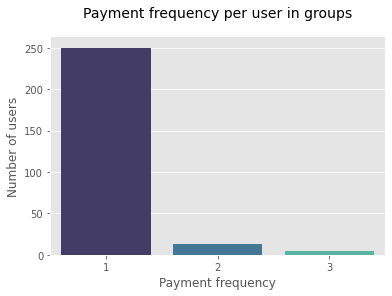

In [464]:
sns.countplot(data = user_revenue_premium, x = 'payment_frequency', palette = 'mako')
plt.xlabel("Payment frequency", size=12)
plt.ylabel("Number of users", size=12)
plt.title('Payment frequency per user in groups', pad = 20, size = 14)
sns.despine()

Данные о транзакциях представлены за период 11 месяцев с января по декабрь.   
Построим распределение количества регистраций в течение всего периода.  
Пользователеи регистрировались в течение всего года с пиками в мае и октябре. Значит, возможность повторно оформить подписку у большего количества пользователей была. Тем не менее, чаще всего пользователи оформляли подписку только 1 раз.

In [465]:
# Первая дата транзакции
transactions_data.query("product_type == ['premium_no_trial', 'trial_premiun']").paid_at.dt.date.min()

datetime.date(2017, 1, 11)

In [466]:
# Последняя дата транзакции
transactions_data.query("product_type == ['premium_no_trial', 'trial_premiun']").paid_at.dt.date.max()

datetime.date(2017, 12, 11)

In [467]:
transactions_data['joined_at'] = transactions_data['joined_at'].dt.date
registration = transactions_data \
                .groupby('joined_at').agg({'uid': 'nunique'}).reset_index()
registration['joined_at'] = registration['joined_at'].apply(lambda x: x.strftime("%d.%m"))        
registration.head()

,joined_at,uid
0,11.01,14
1,11.02,16
2,11.03,13
3,11.04,15
4,11.05,40


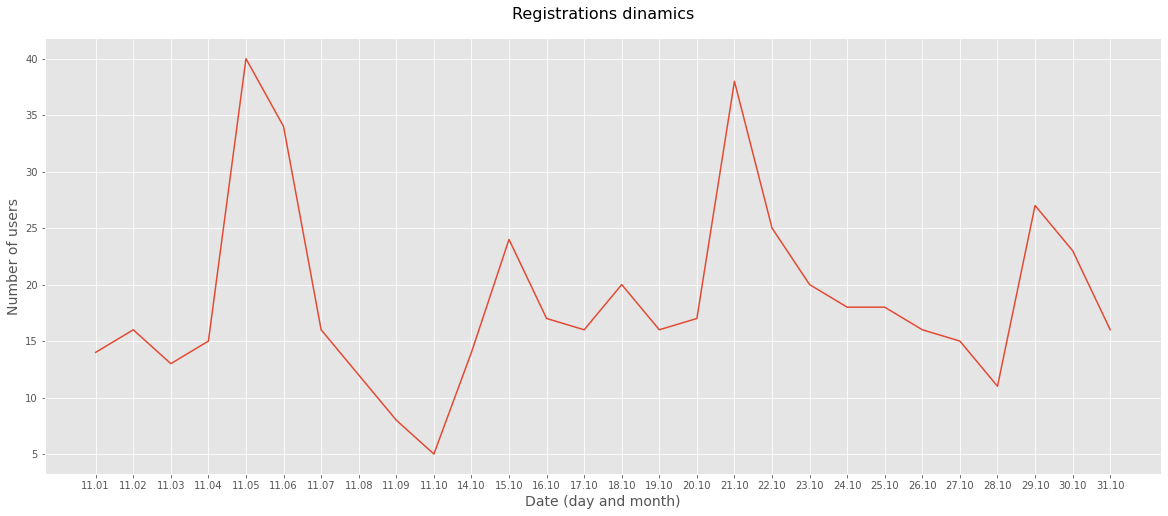

In [468]:
plt.figure(figsize = (20,8))
sns.lineplot(data = registration, x = 'joined_at', y = 'uid')
plt.xlabel("Date (day and month)", size=14)
plt.ylabel("Number of users", size=14)
plt.title('Registrations dinamics', pad = 20, size = 16)
sns.despine()

4. Проверим, имеются ли значимые различия между группами по частоте офомления подписок (payment_frequency) с помощью Хи-квадрата.  
**H0** - частота оформления подписки пользователем не зависит от группы, распределение количества пользователей равномерно.

In [469]:
pd.crosstab(user_revenue_premium.group, user_revenue_premium.payment_frequency)

payment_frequency,1,2,3
group,,,
control_1,91,7,0
control_2,98,3,1
test,61,3,3


In [470]:
stats.chi2_contingency(pd.crosstab(user_revenue_premium.group, user_revenue_premium.payment_frequency))

(7.5805556155872225,
 0.10820914458144011,
 4,
 array([[91.76029963,  4.77153558,  1.46816479],
        [95.50561798,  4.96629213,  1.52808989],
        [62.7340824 ,  3.26217228,  1.00374532]]))

**Вывод:**
Не можем отвергнуть нулевую гипотезу о том, что соотношение частоты оформления подпики пользователем не зависит от группы.  
Это значит, что различия в доходе с пользователя наблюдаются скорее из-за увеличения стоимости подписки, а не из-за того, что пользователи стали чаще оплачивать подписку.

Это хорошо, потому что после увеличения подписки пользователи не стали значимо реже ее оформлять, а доход все равно увеличился. 

### 5. ANOVA по метрике revenue (доход от категорий coins и other_type)

На этапе анализа транзакций мы выяснили, что пользователи переходят с разных страниц перед оплатой разных продуктов. При оплате премиальной или пробной версии подписки это одни страницы, а при оплате внутренней валютой и оплате категории other type это другой набор страниц.  
Поскольку премиум подписка предоставляет доступ к дополнительным возможностям, предполагаем, что пользование внутренней валютой и покупка продуктов из категории other type относится к этим возможностям.  
Проанализируем, есть ли различия в дополнительных тратах, совершаемых премиум-пользователями в группах.

Из всех записей по транзакциям не было и нет подписки у 31 пользователя из 524.  
Большая часть этих пользователей оплачивала продукты за внутреннюю валюту.

In [471]:
transactions_data.uid.nunique()

524

In [472]:
transactions_data.query("is_premium == 0 and was_premium == 0").uid.nunique()

31

In [473]:
transactions_data.query("is_premium == 0 and was_premium == 0").product_type.unique()

array(['coins', 'other_type'], dtype=object)

In [474]:
transactions_data.query("product_type == 'coins' and is_premium == 0 and was_premium == 0").uid.nunique()

24

In [475]:
transactions_data.query("product_type == 'other_type' and is_premium == 0 and was_premium == 0").uid.nunique()

9

Посмотрим на различия в доходе c категорий продуктов **coins, other type** среди пользователей, оформивших подписку в разных группах.
1. Создаем датасет с записями об оплате указанных продуктов пользователями, оформлявшими подписку
2. Строим график распределения дохода
2. Проводим анализ выборок

In [476]:
user_other_revenue = transactions_data.query("product_type == 'other_type' and is_premium !=0 or was_premium != 0") \
                        .groupby(['uid', 'country', 'age', 'gender', 'was_premium', 'is_premium', 'group'], as_index = False) \
                        .agg({'revenue': 'sum', 'paid_at': 'count', 'weeks_until_payment': 'min'}) \
                        .rename(columns ={'paid_at': 'payment_frequency'})
user_other_revenue.head()

,uid,country,age,gender,was_premium,is_premium,group,revenue,payment_frequency,weeks_until_payment
0,891068079.0,Argentina,29,1,1.0,1.0,control_2,10296.0,2,4
1,891071157.0,United States of America,22,1,1.0,1.0,test,9100.0,1,0
2,891075072.0,United States of America,40,1,1.0,1.0,control_2,2327.0,1,5
3,891077727.0,Argentina,20,1,1.0,1.0,control_2,6292.0,1,0
4,891080040.0,Israel,49,1,1.0,1.0,control_2,15132.0,8,5


In [477]:
user_other_revenue.shape

(493, 10)

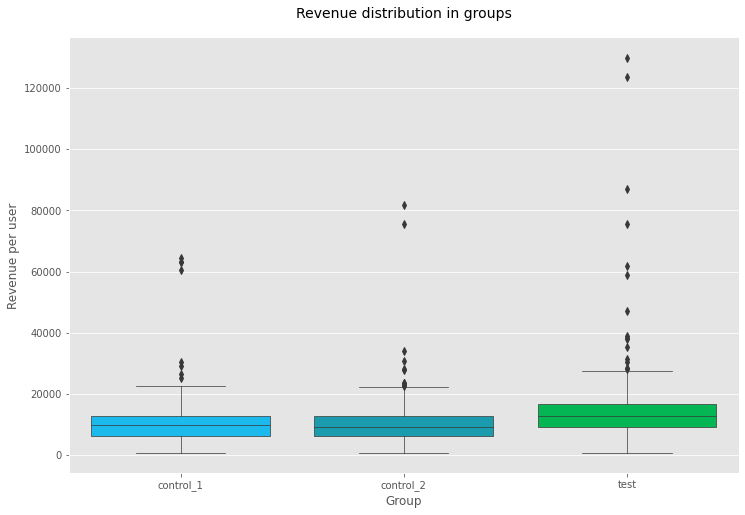

In [478]:
plt.figure(figsize= (12, 8))
sns.boxplot(x = 'group', \
            y = 'revenue', \
            data = user_other_revenue.sort_values('group'), \
            palette = group_palette, \
            saturation = 1,\
            linewidth = 0.7)
plt.xlabel("Group", size=12)
plt.ylabel("Revenue per user", size=12)
plt.title('Revenue distribution in groups', pad = 20, size = 14)
sns.despine()

Проверка выборок на нормальность.  
**H0** - выборка взята из генеральной совокупности, в которой значения распределены нормально  
**Результат** - распределения в выборках значимо отличаются от нормального.

In [479]:
for group in group_names:
    print(group, 'p-value:', '\t', stats.shapiro(user_other_revenue[user_other_revenue.group == group]['revenue'])[1])

test p-value: 	 1.016649123592866e-18
control_1 p-value: 	 2.0465169552658474e-19
control_2 p-value: 	 9.807329930946019e-20


Проверка на гомогенность дисперсии  
**H0** - выборки взяты из генеральных совокупностей с одинаковыми дисперсиями  
**Результат** - дисперсии в группах значимо не различаются 

In [480]:
stats.levene(user_other_revenue[user_other_revenue.group == 'test']['revenue'], \
             user_other_revenue[user_other_revenue.group == 'control_1']['revenue'], \
             user_other_revenue[user_other_revenue.group == 'control_2']['revenue'])

LeveneResult(statistic=4.12808697851337, pvalue=0.016677496174243855)

Выборки не удовлетворяют условию гомогенности дисперсий, для проведения anova используем критерий Уэлча.  

**H0** - ни одно из средних значений в выборках не отличается от других  
**Результат** - среднее хотя бы в одной группе значимо отличается от других

In [481]:
pg.welch_anova(data = user_other_revenue, \
              dv = 'revenue', \
              between = 'group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,286.440776,6.157904,0.002407,0.040056


Попарные сравнения сделаем при помощи теста Геймса-Хоувелла (поправка на различия в дисперсиях).  

**H0 для кадой пары** - средние в группах не имеют значимых различий.  
**Результат** - получили значимые различия в доходе между тестовой и котрольными группами. В тестовой группе доход с пользователя оказался статистически значимо больше.

In [482]:
pg.pairwise_gameshowell(data = user_other_revenue, \
              dv = 'revenue', \
              between = 'group')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,control_1,control_2,11100.393258,10688.08,412.313258,1001.927014,0.411520,350.977663,0.900000,0.043714
1,control_1,test,11100.393258,16570.45,-5470.056742,1702.260329,-3.213408,196.606334,0.004356,-0.362137
2,control_2,test,10688.080000,16570.45,-5882.370000,1702.092347,-3.455964,196.430914,0.001936,-0.390930


Критерий Манна-Уитни  
**H0 для каждого теста** - распределения в выборках значимо не отличаются  

In [483]:
print(f"test + control_1 p-value = {stats.mannwhitneyu(user_revenue_premium[user_revenue_premium.group == 'test']['revenue'], user_revenue_premium[user_revenue_premium.group == 'control_1']['revenue'])[1]}" '\n'
     f"test + control_2 p-value = {stats.mannwhitneyu(user_revenue_premium[user_revenue_premium.group == 'test']['revenue'], user_revenue_premium[user_revenue_premium.group == 'control_2']['revenue'])[1]}" '\n'
     f"control_1 + control_2 p-value = {stats.mannwhitneyu(user_revenue_premium[user_revenue_premium.group == 'control_1']['revenue'], user_revenue_premium[user_revenue_premium.group == 'control_2']['revenue'])[1]}")

test + control_1 p-value = 2.5446059337130588e-08
test + control_2 p-value = 1.5494296303089133e-07
control_1 + control_2 p-value = 0.529541048802848


### 5. Множественный ANOVA по метрике revenue

Проверим, есть ли эффект между определенными группами пользователей.
Разделим пользователей на группы по показателям:
- Возраст (разделениям по процентиллям)
- Количество посещений (разделениям по процентиллям)
- Страна


1. Создаем таблицы с диапазонами значений по возрасту, количеству посещений и населению страны для разбиения пользователей на группы
2. Создаем функции, которые определяют, к какой группе пользователь относится по возрасту age_group(), количеству посещений visits_group()
2. Объединим таблицы users_info, transactions_data c полученными результатами
3. Посмотрим, есть ли разница между группами по доходу от подписки и от иных платежей

In [484]:
age_groups = pd.DataFrame({'age_left': users_info.age.quantile([0, 0.5, 0.75]).values.round(),\
                                'age_right': users_info.age.quantile([ 0.5, 0.75, 1]).values.round()}, \
                               index = (1,2,3))

visits_groups = pd.DataFrame({'vis_left': users_info.visits.quantile([0, 0.5, 0.75]).values.round(),\
                                'vis_right': users_info.visits.quantile([ 0.5, 0.75, 1]).values.round()}, \
                               index = (1,2,3))

In [485]:
age_groups

,age_left,age_right
1,16.0,30.0
2,30.0,38.0
3,38.0,99.0


In [486]:
visits_groups

,vis_left,vis_right
1,0.0,2.0
2,2.0,7.0
3,7.0,31.0


In [487]:
def age_group(age):
    for row in age_groups.itertuples():
        if age >= row.age_left and age < row.age_right:
            group = row.Index
        elif age == row.age_right and row.Index == 3:
            group = row.Index
    return (group)  
users_info['age_group'] = users_info['age'].apply(lambda x: age_group(x))

In [488]:
def visits_group(visits):
    for row in visits_groups.itertuples():
        if visits>= row.vis_left and visits < row.vis_right:
            group = row.Index
        elif visits == row.vis_right and row.Index == 3:
            group = row.Index
    return (group)  
users_info['visits_group'] = users_info['visits'].apply(lambda x: visits_group(x))

Добавим новые столбцы в датасеты, которые будем анализировать дальше

In [489]:
user_revenue_premium = user_revenue_premium.merge(users_info[['uid', 'age_group','visits_group']], on = 'uid', how = 'left')

In [490]:
user_other_revenue = user_other_revenue.merge(users_info[['uid', 'age_group', 'visits_group']], on = 'uid', how = 'left')

In [500]:
transactions_data = transactions_data.merge(users_info[['uid', 'age_group', 'visits_group']], on = 'uid', how = 'left')

Будем считать, что нововведение имеет смысл между группами пользователей, если влияние фактора группы, к которой относится пользователь (по возрасту, количеству посещений или стране) на доход за подписку или от иных трат статистически значимо.  
Для проверки используем множественный ANOVA

**Для стран:**

1. Общий доход с пользователя  
**H0** - доход с пользователя не зависит от страны и группы, к которой принадлежит пользователь, а также от совокупности этих факторов.

In [503]:
formula = 'total_revenue ~ group + country + group:country'
model = ols(formula, transactions_data.drop_duplicates('uid')).fit()
aov_table = anova_lm(model, typ=2)
aov_table

/opt/tljh/user/lib/python3.7/site-packages/statsmodels/base/model.py:1865: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 21, but rank is 9
  'rank is %d' % (J, J_), ValueWarning)
/opt/tljh/user/lib/python3.7/site-packages/statsmodels/base/model.py:1865: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 42, but rank is 34
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
group,1.295613e+09,2.0,4.074979,0.017595
country,4.260961e+09,21.0,1.276345,0.247175
group:country,6.062563e+09,42.0,0.908002,0.620033
Residual,7.487571e+10,471.0,NaN,NaN


2. Доход от премиум-подписки   
**H0** - доход с пользователя не зависит от страны и группы, к которой принадлежит пользователь, а также от совокупности этих факторов.

In [491]:
formula = 'revenue ~ group + country + group:country'
model = ols(formula, user_revenue_premium).fit()
aov_table = anova_lm(model, typ=2)
aov_table

/opt/tljh/user/lib/python3.7/site-packages/statsmodels/base/model.py:1865: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 20, but rank is 11
  'rank is %d' % (J, J_), ValueWarning)
/opt/tljh/user/lib/python3.7/site-packages/statsmodels/base/model.py:1865: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 40, but rank is 31
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
group,7.099081e+08,2.0,2.262098,0.106582
country,4.956563e+09,20.0,1.579392,0.106244
group:country,3.002937e+09,40.0,0.478438,0.991831
Residual,3.405026e+10,217.0,NaN,NaN


3. Доход от категорий coins и other type  
**H0** - доход с пользователя не зависит от страны и группы, к которой принадлежит пользователь, а также от совокупности этих факторов.

In [492]:
formula = 'revenue ~ group + country + group:country'
model = ols(formula, user_other_revenue).fit()
aov_table = anova_lm(model, typ=2)
aov_table

/opt/tljh/user/lib/python3.7/site-packages/statsmodels/base/model.py:1865: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 21, but rank is 9
  'rank is %d' % (J, J_), ValueWarning)
/opt/tljh/user/lib/python3.7/site-packages/statsmodels/base/model.py:1865: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 42, but rank is 34
  'rank is %d' % (J, J_), ValueWarning)


,sum_sq,df,F,PR(>F)
group,2.795809e+09,2.0,8.610281,0.000215
country,2.626755e+09,21.0,0.770442,0.643944
group:country,4.806321e+09,42.0,0.704861,0.893900
Residual,7.143530e+10,440.0,NaN,NaN


**Для групп по количеству посещений:**

1. Общий доход с пользователя  
**H0** - доход с пользователя не зависит от группы, к которой принадлежит пользователь, и группы по количеству посещений, а также от совокупности этих факторов.

In [505]:
formula = 'total_revenue ~ group + visits_group + group:visits_group'
model = ols(formula, transactions_data.drop_duplicates('uid')).fit()
aov_table = anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
group,3.084201e+09,2.0,9.887880,0.000061
visits_group,1.332481e+09,1.0,8.543811,0.003619
group:visits_group,4.510590e+08,2.0,1.446085,0.236439
Residual,8.078658e+10,518.0,NaN,NaN


2. Доход от премиум-подписки   
**H0** - доход с пользователя не зависит от группы, к которой принадлежит пользователь, и группы по количеству посещений, а также от совокупности этих факторов.

In [493]:
formula = 'revenue ~ group + visits_group + group:visits_group'
model = ols(formula, user_revenue_premium).fit()
aov_table = anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
group,1.127685e+09,2.0,3.690037,0.026283
visits_group,2.541441e+06,1.0,0.016632,0.897484
group:visits_group,5.116425e+07,2.0,0.167421,0.845934
Residual,3.988116e+10,261.0,NaN,NaN


3. Доход от категорий coins и other type  
**H0** - доход с пользователя не зависит от группы, к которой принадлежит пользователь, и группы по количеству посещений, а также от совокупности этих факторов.

In [494]:
formula = 'revenue ~ group + visits_group + group:visits_group'
model = ols(formula, user_other_revenue).fit()
aov_table = anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
group,3.258972e+09,2.0,10.411350,0.000037
visits_group,9.735355e+08,1.0,6.220255,0.012960
group:visits_group,5.195812e+08,2.0,1.659892,0.191234
Residual,7.622064e+10,487.0,NaN,NaN


**Для групп по возрасту:**

1. Общий доход с пользователя  
**H0** - доход с пользователя не зависит от группы, к которой принадлежит пользователь, и группы по возрасту, а также от совокупности этих факторов.

In [506]:
formula = 'total_revenue ~ group + age_group + group:age_group'
model = ols(formula, transactions_data.drop_duplicates('uid')).fit()
aov_table = anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
group,3.035435e+09,2.0,9.549901,0.000085
age_group,5.906509e+07,1.0,0.371654,0.542371
group:age_group,1.879406e+08,2.0,0.591287,0.553987
Residual,8.232312e+10,518.0,NaN,NaN


2. Доход от премиум-подписки   
**H0** - доход с пользователя не зависит от группы, к которой принадлежит пользователь, и группы по возрасту, а также от совокупности этих факторов.

In [507]:
formula = 'revenue ~ group + age_group + group:age_group'
model = ols(formula, user_revenue_premium).fit()
aov_table = anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
group,1.171743e+09,2.0,3.849502,0.022510
age_group,2.148798e+07,1.0,0.141188,0.707408
group:age_group,1.907146e+08,2.0,0.626551,0.535234
Residual,3.972266e+10,261.0,NaN,NaN


3. Доход от категорий coins и other type  
**H0** - доход с пользователя не зависит от группы, к которой принадлежит пользователь, и группы по возрасту, а также от совокупности этих факторов.

In [508]:
formula = 'revenue ~ group + age_group + group:age_group'
model = ols(formula, user_other_revenue).fit()
aov_table = anova_lm(model, typ=2)
aov_table

,sum_sq,df,F,PR(>F)
group,3.211568e+09,2.0,10.097657,0.000050
age_group,4.591764e+06,1.0,0.028874,0.865140
group:age_group,2.637892e+08,2.0,0.829393,0.436929
Residual,7.744538e+10,487.0,NaN,NaN


Есть значимое влияние фактора количества визитов на доход от категорий, не связаных с премиальной подпиской.  
Однако, мы не можем утверждать, что данный эффект наблюдается благодаря нововведению.  
Это можно интерпретировать следующим образом: траты пользователя в приложении на категории, не связанные с подпиской, зависят от того, насколько часто пользователь посещает приложение.  
Одновременное влияние фактора количества посещений и группы, к которой относится пользователь, не наблюдается.

## Вывод:
Можно сказать, что эксперимент был успешен, потому что пользователи не стали реже оформлять премиум подписку после изменения ее стоимости, а доход вырос за счет увеличения стоимости подписки.   
При этом доход на пользователя с других категорий трат также статистически значимо увеличился в тестовой группе по сравнению с контрольными.

При сравнении групп значимое влияние на размер дохода от пользователя показал только фактор количества визитов.